# SIR modelling as in: Data-driven approaches for predicting spread of infectious diseases through DINNs: Disease Informed Neural Networks

Notes for self:
SIR stands for 
- Susceptible
- Infective
- Removed (recovered)

S -> I -> R
The transfer rate from S->I is beta. Called transmission rate.
The transfer rate from I->R is alpha. Called recovery rate.

The system of ODE with the 3 variables is as follows. All variables are functions of time t:
dS/dt = -beta * S * I
dI/dt = beta * S * I - alpha * I
dR/dt = alpha I

Assumed that no one has recovered at the onset: 
R(0) = 0
Initial number of Infected is I(0) = I_0

## How DINN's are trained
1. The ODE's are solved with known initial conditions and true parameters (I think they mean alpha, beta etc.).
    This step results in a data series of S, I, R for each t. They use 50-100 points.
    They restrict the parameters around the true values. Not stated by how much.
2. For this set of data points we train using loss from
    - Data point loss
    - ODE loss

Note: I am a unsure how they obtain the parameters alpha beta from the network. They train the network to take in a time t and
output a S, I, R. How does this result in an alpha/beta etc.


In [1]:
from scipy.integrate import solve_ivp
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
#from torchvision.datasets import MNIST
from timeit import default_timer as tdt

import wandb

#from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

if torch.cuda.is_available():
    my_device = 'cuda'
else:
    my_device = 'cpu'
    
has_been_run = True

wandb_on = False

In [2]:
# login in Weights&Biases
if wandb_on:
    wandb.login()

In [3]:
# Time setup
n_days = 1000
t = np.arange(0, n_days+1, 1)

## Disease setup
alpha = 0.01
beta = 0.025

# Initial conditions
N = 1000.0   # Population size
I0 = 100.0/N      # Initial number of infected
R0 = 0.0/N      # Initial number of recovered
S0 = 1 - I0 - R0    # Initial number of susceptible

# Solving the system numerically 

In [4]:
# Solve numerically
def SIR_model_num(t, y, N, beta, alpha):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - alpha * I
    dRdt = alpha * I
    return [dSdt, dIdt, dRdt]

# Setup initial conditions 
y0 = [S0, I0, R0]

# Solve using LSODA method from scipy
sol = solve_ivp(SIR_model_num, [t[0], t[-1]], y0, args=(N/N, beta, alpha), t_eval=t, method='LSODA')

S_data = sol.y[0]
I_data = sol.y[1]
R_data = sol.y[2]
print(sol.message)

The solver successfully reached the end of the integration interval.


Text(0.5, 1.0, 'Numerical Solution to SIR model')

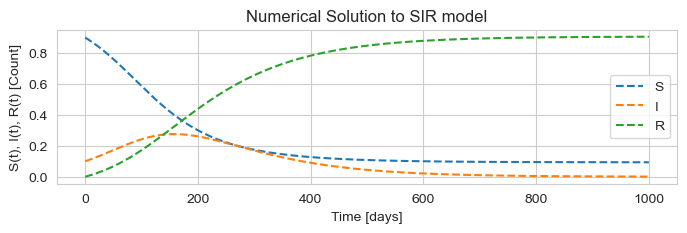

In [5]:
# Plot numerical solution
fig, ax = plt.subplots(1, 1, figsize=(8,2))
ax.plot(t, S_data, linestyle='--', label='S')
ax.plot(t, I_data, linestyle='--', label='I')
ax.plot(t, R_data, linestyle='--', label='R')

ax.set_xlabel('Time [days]')
ax.set_ylabel('S(t), I(t), R(t) [Count]')
ax.legend()
ax.set_title('Numerical Solution to SIR model')

# Training a neural network to solve the ODE system
In the following I will setup a network for solving the system of ODE's (SIR model).
I will assume we know beta and alpha here which is of course cheating. The idea is to figure out what 
network size we need in order to capture the dynamics.
## Description
### Loss functions
Two loss functions will be implemented at first
1. The ODE loss
2. The initial condition loss
Later loss based on data points will be implemented
### Network structure
The input for the network will be time t.
The output of the network will be U. 
where
S = U[0]
I = U[1]
R = U[2]

In [6]:
# ================== Loss functions ==================
# Defining loss function for reasons unknown
torch_MSE_loss = torch.nn.MSELoss()

# Loss for the ODE
def get_loss_ODE(net, t, alpha, beta):
    # Find network solution
    U = net(t)
    S = U[:,0]
    I = U[:,1]
    R = U[:,2]
    
    # Calculate derivatives
    dSdt = torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0].squeeze()
    dIdt = torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0].squeeze()
    dRdt = torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0].squeeze()
    
    # Calculate loss
    # Error1:
    rhs_S = -beta * S * I
    loss1 = torch_MSE_loss(dSdt, rhs_S)
    # Error2:
    rhs_I = beta * S * I - alpha * I
    loss2 = torch_MSE_loss(dIdt, rhs_I)
    # Error3:
    rhs_R = alpha * I
    loss3 = torch_MSE_loss(dRdt, rhs_R)
    
    # Summing the loss. Consider returning all 3 and doing the adaptiveWeight loss on them.
    loss_total = loss1 + loss2 + loss3
    
    return loss_total

# Loss for the initial condition
def get_loss_IC(net, t0, S0, I0, R0):
    # Find network solution
    U = net(t0).view(1,-1)   # reshape as there is only 1 time "t".
    S0_net = U[:,0]
    I0_net = U[:,1]
    R0_net = U[:,2]
    
    # Calculate loss
    loss1 = torch_MSE_loss(S0, S0_net)
    loss2 = torch_MSE_loss(I0, I0_net)
    loss3 = torch_MSE_loss(R0, R0_net)
    
    # Summing the loss. Consider retutning all 3 and doing the adaptiveWeight loss on them.
    loss_total = loss1 + loss2 + loss3 
    
    return loss_total

def get_data_point_loss(net, t_data, S_data, I_data, R_data):
    # Find network solution
    U = net(t_data.view(-1,1))   # reshape as there is only 1 time "t".
    S_net = U[:,0]
    I_net = U[:,1]
    R_net = U[:,2]
    
    # Calculate loss
    loss1 = torch_MSE_loss(S_net, S_data)
    loss2 = torch_MSE_loss(I_net, I_data)
    loss3 = torch_MSE_loss(R_net, R_data)
    
    loss_total = loss1 + loss2 + loss3
    
    return loss_total
    

In [7]:
# ================== Defining the network(s) ==================
class FFN(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size):
        super(FFN, self).__init__()
        
        n_layers = len(hidden_layers_size)
        HL = hidden_layers_size
        
        # Define layers
        self.L1 = nn.Linear(input_size, HL[0])
        self.L2 = nn.Linear(HL[0], HL[1])
        self.L3 = nn.Linear(HL[1], HL[2])
        self.L4 = nn.Linear(HL[2], HL[3])
        self.output = nn.Linear(HL[-1], output_size)
        
        # Define activation function
        self.act_fn = nn.ReLU()

    def forward(self, x):
        # Hidden layers
        x = self.act_fn(self.L1(x))
        x = self.act_fn(self.L2(x))
        x = self.act_fn(self.L3(x))
        x = self.act_fn(self.L4(x))

        # Output layer
        x = self.output(x)
        
        return x

    
# Define network
net = FFN(1, [32,32,32,32], 3).to(my_device)

# Print Network shape
print()
print(net.parameters)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Test the network
print(net(torch.tensor(1.0, device=my_device).view(-1,1)))


<bound method Module.parameters of FFN(
  (L1): Linear(in_features=1, out_features=32, bias=True)
  (L2): Linear(in_features=32, out_features=32, bias=True)
  (L3): Linear(in_features=32, out_features=32, bias=True)
  (L4): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=3, bias=True)
  (act_fn): ReLU()
)>
tensor([[0.0372, 0.1616, 0.1043]], grad_fn=<AddmmBackward0>)


In [8]:
# ================== Testing the loss functions ==================
t_test = torch.linspace(0, 1000, 1001, device=my_device, requires_grad=True).view(-1,1)
t0 = torch.tensor([0.0], device=my_device)

# Converting initial conditions for torch formatting
S0 = torch.tensor([S0], device=my_device)
I0 = torch.tensor([I0], device=my_device)
R0 = torch.tensor([R0], device=my_device)
print(f'Initial Conditions: S0: {S0}, I0: {I0}, R0: {R0}')

# Testing ODE loss
loss_ODE = get_loss_ODE(net, t_test, alpha, beta)
print(loss_ODE)

# Testing IC loss
loss_IC = get_loss_IC(net, t0, S0, I0, R0)
print(loss_IC)

# Move data points to device
if has_been_run:
    t_data = torch.tensor(t, device=my_device, dtype=torch.float32)
    S_data = torch.tensor(S_data, device=my_device, dtype=torch.float32)
    I_data = torch.tensor(I_data, device=my_device, dtype=torch.float32)
    R_data = torch.tensor(R_data, device=my_device, dtype=torch.float32)
has_been_run = False
# Testing data loss
loss_data = get_data_point_loss(net, t_test, S_data, I_data, R_data)
print(loss_data)

Initial Conditions: S0: tensor([0.9000]), I0: tensor([0.1000]), R0: tensor([0.])
tensor(0.1005, grad_fn=<AddBackward0>)
tensor(0.7646, grad_fn=<AddBackward0>)
tensor(117.7628, grad_fn=<AddBackward0>)


### Training the network on the losses

In [9]:
# Loss saving
loss_saved, loss_ODE_saved, loss_IC_saved = [], [], []
#adapt_ode_loss_saved, adapt_IC_loss_saved = [], []
epochs_saved = [0]
# Setup optimizer
learning_rate = 1e-5
weight_decay = 0
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay) #, weight_decay=1e-4

#setup softadapt
lambda_ode = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
lambda_ic = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))
lambda_data = torch.nn.Parameter(torch.tensor([1.0], requires_grad=True))

lr_lambda = 3e-4
optimizer_ode = optim.Adam([lambda_ode], lr=lr_lambda)
optimizer_ic = optim.Adam([lambda_ic], lr=lr_lambda)
optimizer_data = optim.Adam([lambda_data], lr=lr_lambda)

In [ ]:
## With sequential learning

# Training setup
num_epochs = 10000
save_every_epochs = 100

# Define the number of slices for the sequential learning sampling frequency
n_sequences = 10
sampling_frequency = 200

# Define sampling points
data_samples = torch.arange(1, n_days, sampling_frequency, device=my_device, dtype=torch.float32, requires_grad=True).view(-1,1)

# Calculate the size of each slice
slice_size = t.size // n_sequences
last_slice_size = int(t.size - slice_size * (n_sequences - 1))

# create time tensor
t_tensor = torch.arange(0, n_days, 1, device=my_device, dtype=torch.float32, requires_grad=True).view(-1,1)

losses, ode_losses, ic_losses, data_losses = [], [], [], []

net = net.to(my_device)

# Initialize variables to track the lowest loss and best model state
lowest_loss = float('inf')
best_model_state = None

# start a new wandb run to track this script
if wandb_on:
    wandb.init(
        # set the wandb project where this run will be logged
        project="SIR_PINN_test",

        # track hyperparameters and run metadata
        config={
        "learning_rate": learning_rate,
        "architecture": "FFNN (4*32)",
        "activation function" : "ReLU",
        "Weight decay": weight_decay,
        "epochs": num_epochs,
        "ODE loss": "yes",
        "IC loss": "yes",
        "Data points": "true",
        "Seq learn": "true"
        }
    )

# Track gradients in wandb
if wandb_on:
    wandb.watch(net, log_freq=10)

# Train model with sequential learning
for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss, ode_loss, ic_loss, data_loss = 0, 0, 0, 0
    net.train()
    
    for slice_num in range(n_sequences):
        # Determine the range of this slice
        start_idx = slice_num * slice_size
        if slice_num == n_sequences - 1:  # Last slice
            end_idx = start_idx + last_slice_size
        else:
            end_idx = start_idx + slice_size
        
        t_samples = t_tensor[start_idx:end_idx]
            
        optimizer.zero_grad()
        optimizer_ode.zero_grad()
        optimizer_ic.zero_grad()
        optimizer_data.zero_grad()

        #output = net(t_samples)
        
        # Find indices in t_data that fall within t_range
        #valid_indices = np.where((t_data >= t_samples[0]) & (t_data <= t_samples[-1]))[0]
        
        # Sample from these indices according to sample_frequency
        #sampled_indices = valid_indices[::sample_frequency]
        
        t_data_batch = torch.tensor([x for x in data_samples if x in t_samples],
                            device=data_samples.device, dtype=data_samples.dtype).numpy()
        
        # Calculate loss
        batch_loss_ode = get_loss_ODE(net, t_samples, alpha, beta)
        batch_loss_ic = get_loss_IC(net, t0, S0, I0, R0)
        if t_data_batch.size != 0:
            batch_loss_data = get_data_point_loss(net, t_data[t_data_batch], S_data[t_data_batch], I_data[t_data_batch], R_data[t_data_batch])
        
        if t_data_batch.size != 0:
            batch_loss = lambda_ode * batch_loss_ode + lambda_ic * batch_loss_ic + lambda_data * batch_loss_data
        elif t_data_batch.size == 0:
            batch_loss = lambda_ode * batch_loss_ode + lambda_ic * batch_loss_ic
        
        batch_loss.backward()
    
            
        #maximize gradients of lambdas by inverting the gradient
        with torch.no_grad():
            lambda_ode.grad *= -1
            lambda_ic.grad *= -1
            lambda_data.grad *= -1
            
        optimizer.step()
        optimizer_ode.step()
        optimizer_ic.step()
        optimizer_data.step()
        
        cur_loss += batch_loss.detach().numpy()
        ode_loss += batch_loss_ode.detach().numpy()
        ic_loss += batch_loss_ic.detach().numpy()
        data_loss += batch_loss_data.detach().numpy()
        
         # Update loss tracking
        epoch_loss = cur_loss
        if epoch_loss < lowest_loss:
            lowest_loss = epoch_loss
            best_model_state = net.state_dict().copy()  # Save the best model state

        
    # log metrics to wandb
    if wandb_on:
        wandb.log({"loss": cur_loss, "ode_loss": ode_loss, "ic_loss": ic_loss, "data_loss": data_loss})
        
    losses.append(cur_loss)
    ode_losses.append(ode_loss)
    ic_losses.append(ic_loss)
    data_losses.append(data_loss)

    net.eval()
    
    if (epoch+1) % save_every_epochs == 0 or epoch == 0:
        print(f"Epoch {epoch+1:5}, Loss: {losses[-1].item():9.5f}, ode_loss: {ode_losses[-1].item():7.7f}, ic_loss: {ic_losses[-1].item():7.7f}, data_loss: {data_losses[-1].item():7.7f}"
                f", aw_ode: {lambda_ode.item():3.2f}, aw_ic: {lambda_ic.item():3.2f}, aw_data: {lambda_data.item():3.2f}")
        
# After training, load the best model state
net.load_state_dict(best_model_state)

Epoch     1, Loss: 420.37814, ode_loss: 0.5914073, ic_loss: 7.6371033, data_loss: 823.1676638, aw_ode: 1.00, aw_ic: 1.00, aw_data: 1.00
Epoch   100, Loss:  11.35388, ode_loss: 0.0009669, ic_loss: 6.5076960, data_loss: 5.6383519, aw_ode: 1.10, aw_ic: 1.29, aw_data: 1.05
Epoch   200, Loss:   9.19722, ode_loss: 0.0000224, ic_loss: 5.4079073, data_loss: 1.4370264, aw_ode: 1.10, aw_ic: 1.56, aw_data: 1.06
Epoch   300, Loss:   8.03668, ode_loss: 0.0000278, ic_loss: 4.0862091, data_loss: 1.2000995, aw_ode: 1.10, aw_ic: 1.81, aw_data: 1.06
Epoch   400, Loss:   5.94893, ode_loss: 0.0000467, ic_loss: 2.6851883, data_loss: 0.9449811, aw_ode: 1.10, aw_ic: 2.03, aw_data: 1.06
Epoch   500, Loss:   3.69451, ode_loss: 0.0000656, ic_loss: 1.5029061, data_loss: 0.7140774, aw_ode: 1.10, aw_ic: 2.21, aw_data: 1.06
Epoch   600, Loss:   1.55630, ode_loss: 0.0001556, ic_loss: 0.5500439, data_loss: 0.5161314, aw_ode: 1.10, aw_ic: 2.33, aw_data: 1.07
Epoch   700, Loss:   0.40776, ode_loss: 0.0002315, ic_loss: 

In [ ]:
# finish the wandb run
if wandb_on:
    wandb.finish()

In [ ]:
print(net(t0))

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(losses, label='loss')
ax.plot(ode_losses, label='ODE loss')
ax.plot(ic_losses, label='IC loss')
ax.legend()

In [ ]:
net_cpu = net.to('cpu')

U = net_cpu(torch.tensor(t).float().view(-1,1))
S_net = U[:,0]
I_net = U[:,1]
R_net = U[:,2]

# Plot numerical solution
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(t, S_net.detach().numpy(), linestyle='-', label='S_net', color='blue')
ax.plot(t, I_net.detach().numpy(), linestyle='-', label='I_net', color='red')
ax.plot(t, R_net.detach().numpy(), linestyle='-', label='R_net', color='green')
ax.plot(t, S_data.clone().to('cpu'), linestyle='--', label='S_num', color='blue')
ax.plot(t, I_data.clone().to('cpu'), linestyle='--', label='I_num', color='red')
ax.plot(t, R_data.clone().to('cpu'), linestyle='--', label='R_num', color='green')

ax.set_xlabel('Time [days]')
ax.set_ylabel('S(t), I(t), R(t) [Count]')
ax.legend() 
ax.set_title('Numerical Solution to SIR model')


In [ ]:
# check stuff using numpy and gradient
S_net_np = S_net.detach().numpy()
I_net_np = I_net.detach().numpy()
R_net_np = R_net.detach().numpy()

# Running the sdfh nioa
dSdt = np.gradient(S_net_np)
dIdt = np.gradient(I_net_np)
dRdt = np.gradient(R_net_np)

rhs_S = beta * S_net_np * I_net_np
rhs_I = -beta * S_net_np * I_net_np + alpha * I_net_np
rhs_R = -alpha * I_net_np

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(dSdt, color='blue', linestyle='-', label='dSdt')
ax.plot(rhs_S, color='blue', linestyle='--', label='rhs_S')
ax.plot(dIdt, color='red', linestyle='-', label='dSdt')
ax.plot(rhs_I, color='red', linestyle='--', label='rhs_S')
ax.plot(dRdt, color='green', linestyle='-', label='dSdt')
ax.plot(rhs_R, color='green', linestyle='--', label='rhs_S')
ax.set_ylim(-0.01, 0.01)
ax.legend()

In [1]:
t_data_batch

NameError: name 't_data_batch' is not defined